In [1]:
%load_ext autotime
%load_ext autoreload
%autoreload 2

In [2]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import typing
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm

from tqdm.auto import tqdm
from collections import defaultdict, Counter
from IPython.display import clear_output

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('figure', **{'dpi': 300})

time: 2.05 s


# Часть первая, с блекджеком и стратегиями

## Задание 1

Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. 

Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

#### Загрузим среду

In [3]:
env = gym.make('Blackjack-v0')

time: 34.7 ms


Посмотрим ее характеристики

In [4]:
print(env.action_space)
print(env.observation_space)
print(env.reward_range)
print(env.dealer)

Discrete(2)
Tuple(Discrete(32), Discrete(11), Discrete(2))
(-inf, inf)
[3, 8]
time: 30.4 ms


#### Реализуем простую стратегию

In [28]:
def simple_policy(observation):
    if observation[0] in [19, 20, 21]:
        return 0  # stand
    return 1  # hit

time: 29.9 ms


#### Сыграем с этой стратегией много раз(сэмплирование) и оценим ожидаемую награду(Монте-Карло)

In [29]:
n_experiments = 200000
rewards = []
env = gym.make('Blackjack-v0')

for _ in tqdm(range(n_experiments)):
    state = env.reset()
    while True:
        action = simple_policy(state)
        state, reward, done, info = env.step(action)
        if done:
            rewards.append(reward)
            break

env.close()
print(f"Expected reward for simple policy: {np.mean(rewards)}")

Expected reward for simple policy: -0.199745
time: 15 s


Как и ожидалось эта стратегия уверенно проигрывает казино.

## Задание 2
Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

Идеей importance sampling я проникся(действительно клевый трюк), но хотелось бы ждать сходимости поменьше, поэтому мое сердечко склоняется к Q-learning)))

In [7]:
class QLearningAgent:
    """ Agent, which fit policy by Off-Policy TD control(Q-learning). """
    
    def __init__(self, actions_list: typing.List[int], alpha: float = 1e-3, gamma: float = 1.0):
       # random initialization of Q[s][a]
        self.Q = defaultdict(lambda: [
            np.random.rand() #* alpha * 10
            for action in actions_list
        ])
#         self.Q = defaultdict(lambda: [
#             0
#             for action in actions_list
#         ])
        
        self.alpha = alpha
        self.gamma = gamma
        self._actions_list = actions_list
        
    def get_action(self, s) -> int:
        return self._actions_list[np.argmax(self.Q[s])]
    
    def update(self, s, a, r, next_s):
        if next_s[0] > 21 and next_s not in self.Q:
            # hack for terminal stage
            for next_a in self._actions_list:
                self.Q[next_s][next_a] = 0
        
        self.Q[s][a] += self.alpha * (r + self.gamma * np.max(self.Q[next_s]) - self.Q[s][a])

time: 39.5 ms


К тому же захотелось попробовать DoubleQLearning

In [8]:
class DoubleQLearningAgent:
    """ Agent, which fit policy by Off-Policy TD control(Q-learning) + double. """
    
    def __init__(self, actions_list: typing.List[int], alpha: float = 1e-3, gamma: float = 1.0):
       # random initialization of Q[s][a]
        self.Q_1 = defaultdict(lambda: [
            np.random.rand() #* alpha * 10
            for action in actions_list
        ])
        self.Q_2 = defaultdict(lambda: [
            np.random.rand() #* alpha * 10
            for action in actions_list
        ])
        
        self.alpha = alpha
        self.gamma = gamma
        self._actions_list = actions_list
        
    def get_action(self, s) -> int:
        if np.random.rand() < 0.5:
            Q = self.Q_1
        else:
            Q = self.Q_2
        return self._actions_list[np.argmax(Q[s])]
    
    def update(self, s, a, r, next_s):
        Q_cur, Q_next = self.Q_1, self.Q_2
        if np.random.rand() < 0.5:
            Q_cur, Q_next = Q_next, Q_cur
        
        if next_s[0] > 21 and next_s not in Q_next:
            # hack for terminal stage
            for next_a in self._actions_list:
                Q_next[next_s][next_a] = 0
        
        Q_cur[s][a] += self.alpha * (r + self.gamma * np.max(Q_next[next_s]) - Q_cur[s][a])
        
    def mae(self) -> float:
        diff_list = []
        
        for s in self.Q_1:
            for a in self._actions_list:
                diff_list.append(self.Q_2[s][a] - self.Q_1[s][a])

        return np.mean(np.abs(np.array(diff_list)))

time: 29.7 ms


In [9]:
class EGreedyDoubleQLearningAgent:
    """ Agent, which fit policy by Off-Policy TD control(Q-learning) + double + e-greedy. """
    
    def __init__(self, actions_list: typing.List[int], alpha: float = 1e-3, gamma: float = 1.0, epsilon: float = 0.5):
       # random initialization of Q[s][a]
        self.Q_1 = defaultdict(lambda: [
            np.random.rand() #* alpha * 10
            for action in actions_list
        ])
        self.Q_2 = defaultdict(lambda: [
            np.random.rand() #* alpha * 10
            for action in actions_list
        ])
        
        self.alpha = alpha
        self.gamma = gamma
        self._actions_list = actions_list
        
        self._max_epsilon = epsilon
        self.epsilon = epsilon
        self._iter = 0
        
    def get_action(self, s) -> int:
        # faster than np.random.choice x2 + argmax + always choose Q-function
        if np.random.rand() < self.epsilon:
            return np.random.choice(self._actions_list)
        else:
            if np.random.rand() < 0.5:
                Q = self.Q_1
            else:
                Q = self.Q_2
            return self._actions_list[np.argmax(Q[s])]
    
    def update(self, s, a, r, next_s):
        self._iter += 1
        if self._iter % 100000 == 0:
            # heuristic
            self.epsilon = np.min([self._max_epsilon, self.mae()])
            print(f"iter: {self._iter}, epsilon: {self.epsilon:.5f}")
            
        Q_cur, Q_next = self.Q_1, self.Q_2
        if np.random.rand() < 0.5:
            Q_cur, Q_next = Q_next, Q_cur
        
        if next_s[0] > 21 and next_s not in Q_next:
            # hack for terminal stage
            for next_a in self._actions_list:
                Q_next[next_s][next_a] = 0
        
        Q_cur[s][a] += self.alpha * (r + self.gamma * np.max(Q_next[next_s]) - Q_cur[s][a])
        
    def mae(self) -> float:
        diff_list = []
        
        for s in self.Q_1:
            for a in self._actions_list:
                diff_list.append(self.Q_2[s][a] - self.Q_1[s][a])

        return np.mean(np.abs(np.array(diff_list)))

time: 28.6 ms


Для дальнейшего удобства реализуем функцию, которая обучает произвольного агента и отображает текущий прогресс.

In [20]:
def train_agent(
    agent, 
    env, 
    n_experiments: int = 100000, 
    verbose: bool = False, 
    n_iter_val: int = 10000,
    n_iter_mean: int = 1000,
) -> typing.Tuple[typing.List[float], typing.List[float]]:
    """Train agent, return rewards and display current reward graph. """
    
    epochs = [-1]
    rewards = [0]
    mean_rewards = [0]
    
    progress = tqdm(range(n_experiments))
    for i in progress:
        progress.update()
        state = env.reset()
        while True:
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            agent.update(state, action, reward, next_state)
            if done:
                epochs.append(i)
                rewards.append(reward)
                if i <= n_iter_mean:
                    mean_rewards.append((mean_rewards[-1] * i + reward) / (i + 1))
                else:
                    mean_rewards.append(
                        mean_rewards[-1] + (reward - rewards[-n_iter_mean]) / n_iter_mean
                    )
                break
        
        if (i + 1) % n_iter_val == 0:
            clear_output()
            progress.display()
            fig = plot_rewards(epochs[20:], mean_rewards[20:])
            plt.show()
            decr_factor = 10
            epochs = epochs[::decr_factor]
            mean_rewards = mean_rewards[::decr_factor]
            rewards = rewards[-(n_iter_mean + 1):]
    
    progress.close()
    return epochs, rewards, mean_rewards

time: 27.5 ms


In [11]:
def plot_rewards(epochs: typing.List[int], rewards: typing.List[float]):
    figure = plt.figure(figsize=(14, 8))
    ax = figure.add_subplot(1, 1, 1)
    
    ax.plot(epochs, rewards)
    ax.set_title("Rewards")
    ax.set_xlabel("epoch")
    ax.set_ylabel("reward")

    return figure

time: 25.8 ms


## Задание 3
Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

Для удобства буду считать гамму равной 1, так как нам не важно, победим мы с двумя или с четырмя картами на руках.

alpha подбирал в логарифмической шкале(1e-1, 1e-2, 1e-3, 1e-4, 1e-5). 

При alpha = 1e-4 сходится +/- нормальной скоростью и не так сильно начинает расходиться.

### Q-learning

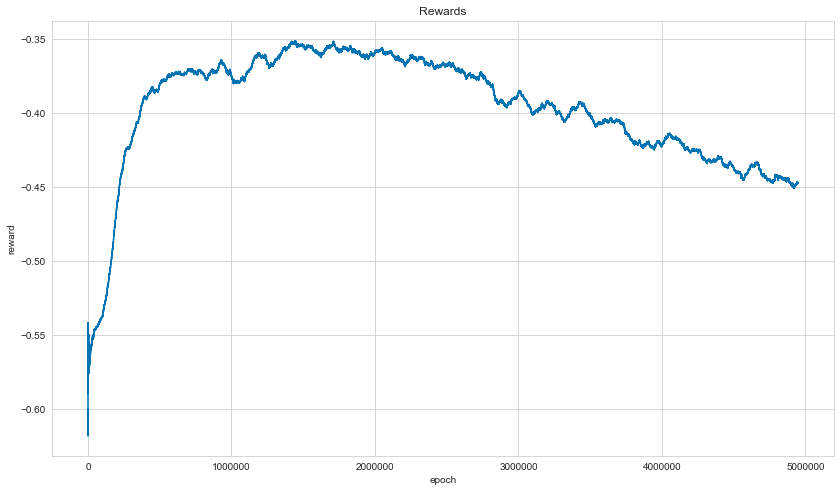

time: 10min 20s


In [68]:
actions_list = [0, 1]
alpha = 1e-4
gamma = 1
n_experiments = 5000000
n_iter_val = 150000
n_iter_mean = 100000

agent = QLearningAgent(actions_list=actions_list, alpha=alpha, gamma=gamma)
env = gym.make('Blackjack-v0')

rewards, mean_rewards = train_agent(
    agent=agent, env=env, n_experiments=n_experiments, 
    verbose=True, n_iter_val=n_iter_val, n_iter_mean=n_iter_mean,
)
env.close()

Посмотрим на значения Q-функции:

In [72]:
q_agent = agent

time: 31 ms


In [73]:
sorted(q_agent.Q.items())

[((4, 1, False), [0.35399679346152957, 0.35399556723362374]),
 ((4, 2, False), [0.9170065171890498, 0.07570432260333193]),
 ((4, 3, False), [0.47220800752601677, 0.10727739370697931]),
 ((4, 4, False), [0.20765776974227834, 0.2972617182894004]),
 ((4, 5, False), [0.11794510643158274, 0.43453941315990047]),
 ((4, 6, False), [0.6696238728918177, 0.4689996916035837]),
 ((4, 7, False), [0.017567292737050932, 0.19729963455693916]),
 ((4, 8, False), [0.6766344655287428, 0.6767507145351499]),
 ((4, 9, False), [0.7694774772455432, 0.39121406532232506]),
 ((4, 10, False), [0.26354891503558503, 0.26358762782911727]),
 ((5, 1, False), [0.20156886809718694, 0.20169414238407166]),
 ((5, 2, False), [0.06737958267624045, 0.17889706715856332]),
 ((5, 3, False), [0.47922526999725434, 0.24290760849155635]),
 ((5, 4, False), [0.10211294088206802, 0.2477138999068943]),
 ((5, 5, False), [0.12419033264582191, 0.1291519024829463]),
 ((5, 6, False), [0.09405573604778117, 0.13814670731503412]),
 ((5, 7, False)

time: 88.4 ms


Стратегия так себе: даже не при всех 21 предпочитает закончить брать карты(

Получается средний reward значительно ниже, чем у подхода, основанного на правилах. Попробую DoubleQLearning.

### DoubleQLearning

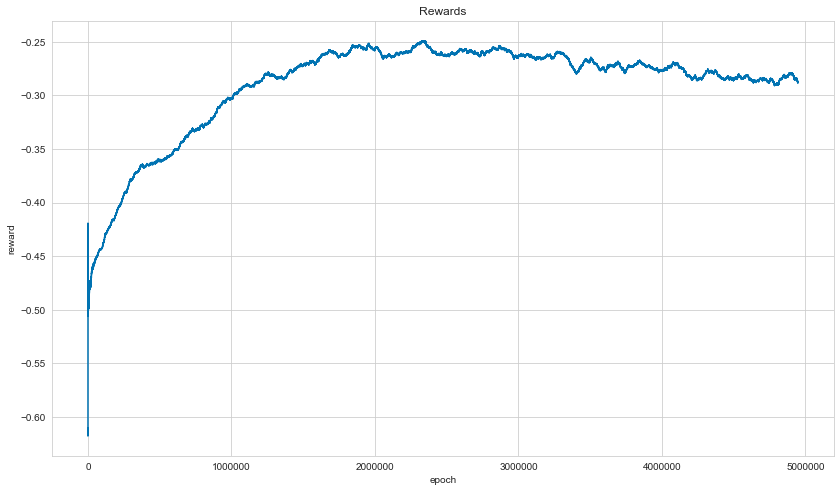

time: 10min 27s


In [74]:
actions_list = [0, 1]
alpha = 1e-4
gamma = 1
n_experiments = 5000000
n_iter_val = 150000
n_iter_mean = 100000

agent = DoubleQLearningAgent(actions_list=actions_list, alpha=alpha, gamma=gamma)
env = gym.make('Blackjack-v0')

rewards, mean_rewards = train_agent(
    agent=agent, env=env, n_experiments=n_experiments, 
    verbose=True, n_iter_val=n_iter_val, n_iter_mean=n_iter_mean,
)
env.close()

reward стал сильно лучше!

In [75]:
double_q_agent = agent

time: 32.7 ms


In [76]:
sorted(double_q_agent.Q_1.items())

[((4, 1, False), [0.2932687262642383, 0.8134084652550724]),
 ((4, 2, False), [0.7122672021140837, 0.05667706582724985]),
 ((4, 3, False), [0.8466086388251489, 0.3193888181028126]),
 ((4, 4, False), [0.031090443284832802, 0.8944317606009279]),
 ((4, 5, False), [0.3763918270701959, 0.7526943855483146]),
 ((4, 6, False), [0.6808571105656939, 0.13860319794912943]),
 ((4, 7, False), [0.1624536922600399, 0.13435708284779557]),
 ((4, 8, False), [0.6188731111022006, 0.4818049043106996]),
 ((4, 9, False), [0.35360826650094307, 0.32513295109981816]),
 ((4, 10, False), [0.5766520754791995, 0.022817322429152798]),
 ((5, 1, False), [0.0734286466073596, 0.20740205468747847]),
 ((5, 2, False), [0.7060403309082044, 0.5824326674615943]),
 ((5, 3, False), [0.7519267107130205, 0.2587130889265452]),
 ((5, 4, False), [0.5865178792754312, 0.5976162622591948]),
 ((5, 5, False), [0.8352195616263972, 0.04999165023283281]),
 ((5, 6, False), [0.7287043771379019, 0.2831986402416081]),
 ((5, 7, False), [0.36993089

time: 70.4 ms


In [77]:
sorted(double_q_agent.Q_2.items())

[((4, 1, False), [0.1144729370558464, 0.11420425847150745]),
 ((4, 2, False), [0.47228598485096807, 0.057357726045523805]),
 ((4, 3, False), [0.7151369014740409, 0.6727395129890156]),
 ((4, 4, False), [0.37161232162265556, 0.35226479756806856]),
 ((4, 5, False), [0.8758405505011875, 0.6327283708502071]),
 ((4, 6, False), [0.12309211313213361, 0.3170497236053447]),
 ((4, 7, False), [0.14300496063459933, 0.055907353101861235]),
 ((4, 8, False), [0.24090165845508185, 0.25282741444855966]),
 ((4, 9, False), [0.33572712369415525, 0.5269602720358059]),
 ((4, 10, False), [0.6521927247109496, 0.2667070777393047]),
 ((5, 1, False), [0.2738611220215521, 0.4012606784731806]),
 ((5, 2, False), [0.4726934454374352, 0.3606687919423971]),
 ((5, 3, False), [0.3037285904124542, 0.6281117827262225]),
 ((5, 4, False), [0.18838391469667384, 0.1308941936903723]),
 ((5, 5, False), [0.4716257899142588, 0.33619364754742864]),
 ((5, 6, False), [0.3472704796979875, 0.08880859385321815]),
 ((5, 7, False), [0.205

time: 72.1 ms


In [78]:
print(f"MAE of two Q-functions: {double_q_agent.mae():.4f}")

MAE of two Q-functions: 0.1545
time: 31.7 ms


Значения Q-функций заметно отличаются - видно, что модель не сошлась.

Возможно, они и не должны сойтись, потому что некоторые пары (s, a) не обновляются из-за того, что они довольно быстро стали очевидно не выйгрышными(типо брать карту при 21). Значения Q для окончания игры практически одинаковые.

Попробую добавить e-greedy, чтобы точно исследовать все пространство.

### EGreedyDoubleQLearningAgent

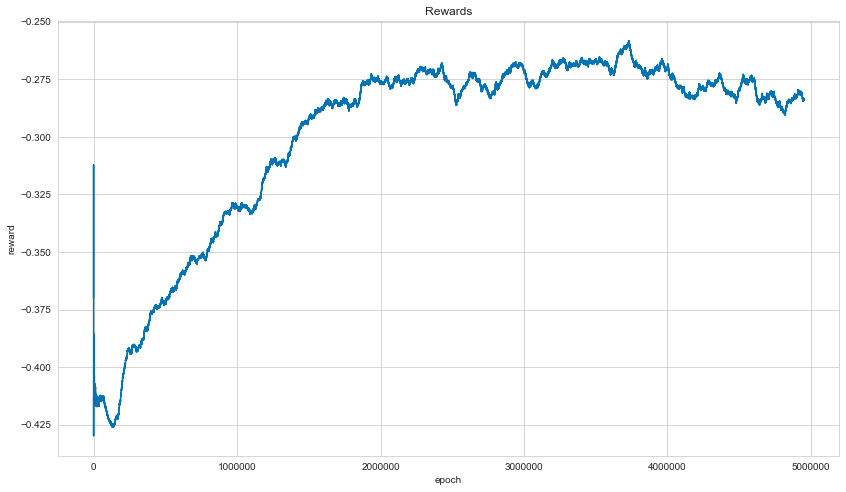

iter: 6600000, epsilon: 0.14551
time: 10min 42s


In [82]:
actions_list = [0, 1]
alpha = 1e-4
gamma = 1
n_experiments = 5000000
n_iter_val = 150000
n_iter_mean = 100000

agent = EGreedyDoubleQLearningAgent(actions_list=actions_list, alpha=alpha, gamma=gamma)
env = gym.make('Blackjack-v0')

rewards, mean_rewards = train_agent(
    agent=agent, env=env, n_experiments=n_experiments, 
    verbose=True, n_iter_val=n_iter_val, n_iter_mean=n_iter_mean,
)
env.close()

reward примерно такой же, но если запустить на подольше, то думаю, что вариант с e-greedy имеет больше шансов, чем два других.

In [83]:
epsilon_double_q_agent = agent

time: 61.3 ms


In [84]:
sorted(epsilon_double_q_agent.Q_1.items())

[((4, 1, False), [0.5175159496447769, 0.09958505812247691]),
 ((4, 2, False), [0.7656509498026681, 0.10824502434582037]),
 ((4, 3, False), [0.31479825120398947, 0.46545785863687567]),
 ((4, 4, False), [0.348791126263372, 0.4721500846073985]),
 ((4, 5, False), [0.33726030424506204, 0.0405903798964972]),
 ((4, 6, False), [0.32753782689149896, 0.7851461334112411]),
 ((4, 7, False), [0.45715038420896037, 0.10265780493854844]),
 ((4, 8, False), [0.18348948691091677, 0.5982485881512312]),
 ((4, 9, False), [0.2680564768758667, 0.6965502754559456]),
 ((4, 10, False), [0.3243050983820214, 0.08570525937919618]),
 ((5, 1, False), [0.5610784006075836, 0.014600340840437749]),
 ((5, 2, False), [0.08384567010287765, 0.068882814707991]),
 ((5, 3, False), [0.5541549209504707, 0.7270988127791763]),
 ((5, 4, False), [0.34146568476853967, 0.18040714090057278]),
 ((5, 5, False), [0.34625760463516947, 0.41059685475017693]),
 ((5, 6, False), [0.10825894297972893, 0.5549844572018994]),
 ((5, 7, False), [0.639

time: 76.4 ms


In [85]:
sorted(epsilon_double_q_agent.Q_2.items())

[((4, 1, False), [0.3940098206858445, 0.081267905235585]),
 ((4, 2, False), [0.7023132943769724, 0.777887344121757]),
 ((4, 3, False), [0.4713512053926312, 0.13505675700761902]),
 ((4, 4, False), [0.7119408863167417, 0.21258192158889924]),
 ((4, 5, False), [0.6831435504819081, 0.2593890107274639]),
 ((4, 6, False), [0.8065633421021877, 0.6228200051574501]),
 ((4, 7, False), [0.5339516115739663, 0.2881447928961584]),
 ((4, 8, False), [0.11888200806930577, 0.10927538625654375]),
 ((4, 9, False), [0.07289827347588287, 0.42567816007072223]),
 ((4, 10, False), [0.32872313475787796, 0.1655318105519958]),
 ((5, 1, False), [0.693079053375873, 0.3547561657585547]),
 ((5, 2, False), [0.5860637913120047, 0.31055774968372235]),
 ((5, 3, False), [0.8716815534092673, 0.2534267443324246]),
 ((5, 4, False), [0.3550582960847622, 0.38396840740519045]),
 ((5, 5, False), [0.5260881140275264, 0.4908237089953849]),
 ((5, 6, False), [0.4113612361758341, 0.4049946972337711]),
 ((5, 7, False), [0.4138619743716

time: 87.3 ms


In [86]:
print(f"MAE of two Q-functions: {epsilon_double_q_agent.mae():.4f}")
print(f"iter: {epsilon_double_q_agent._iter}, epsilon: {epsilon_double_q_agent.epsilon:.5f}")

MAE of two Q-functions: 0.1451
iter: 6645183, epsilon: 0.14551
time: 44.5 ms


Попробую запустить на большее число эпох, если останется время, а пока перейду к следующей части.

# Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:


**double** — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.


## Задание 4

Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

In [44]:
import gym
from gym import spaces
from gym.utils import seeding


def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class DoubleBlackjackEnv(gym.Env):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1 or action == 2:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
                
        
        if action == 0 or action == 2:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
                
        
        if action == 2:  # double: add a card to players hand and play out the dealers hand, and score x2
            # we take card and play out the dealers hand in prev "if" blocks
            reward *= 2
        
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

time: 158 ms


## Задание 5

Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

### EGreedyDoubleQLearningAgent

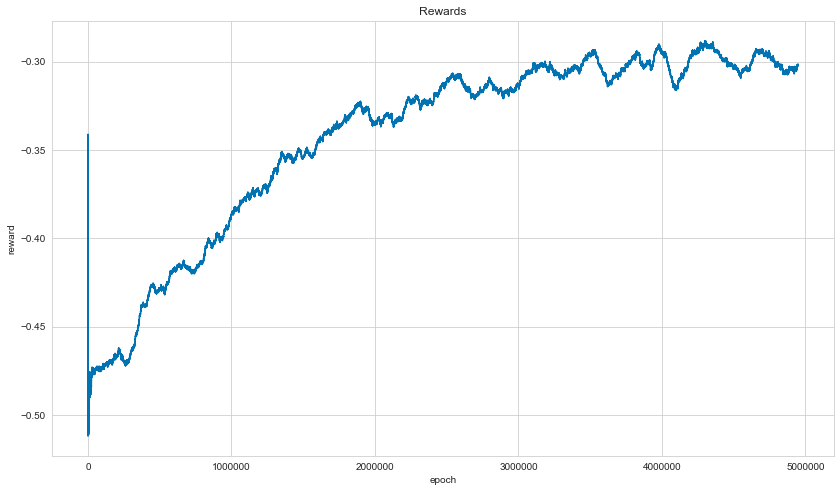

time: 10min 23s


In [95]:
actions_list = [0, 1, 2]
alpha = 1e-4
gamma = 1
n_experiments = 5000000
n_iter_val = 150000
n_iter_mean = 100000

agent = EGreedyDoubleQLearningAgent(actions_list=actions_list, alpha=alpha, gamma=gamma)
env = DoubleBlackjackEnv()

rewards, mean_rewards = train_agent(
    agent=agent, env=env, n_experiments=n_experiments, 
    verbose=True, n_iter_val=n_iter_val, n_iter_mean=n_iter_mean,
)
env.close()

Что-то e-greedy стала даже хуже. Я все равно в нее верю, но на большем числе итераций(чтобы эвристика с mae сработала).

На всякий случай проверю без e-greedy.

In [96]:
dbj_epsilon_double_q_agent = agent

time: 56.9 ms


In [97]:
sorted(dbj_epsilon_double_q_agent.Q_1.items())

[((4, 1, False), [0.6597163118306164, 0.6983134008039023, 0.5989314595616325]),
 ((4, 2, False),
  [0.8844332731557953, 0.6884566383164229, 0.0045291010186031405]),
 ((4, 3, False), [0.5755931162832718, 0.5931346058323063, 0.5801250237614547]),
 ((4, 4, False),
  [0.2819427837336286, 0.26715682928648204, 0.5228402530814975]),
 ((4, 5, False),
  [0.17387552245549706, 0.4617772387811485, 0.6542184916157308]),
 ((4, 6, False),
  [0.016601108225959896, 0.220195299006231, 0.40430221115886955]),
 ((4, 7, False),
  [0.31301485892247155, 0.5137273446921201, 0.3997876386372882]),
 ((4, 8, False), [0.1591259998971306, 0.8278066176799614, 0.8283082001812732]),
 ((4, 9, False), [0.686921581501179, 0.938401332628019, 0.5027145867977293]),
 ((4, 10, False), [0.698389240463097, 0.2985393318055861, 0.6987620679392713]),
 ((5, 1, False), [0.7209723642565171, 0.6671140708148465, 0.5134593831403902]),
 ((5, 2, False), [0.6023429732850667, 0.747409069610357, 0.4815114802407481]),
 ((5, 3, False),
  [0.768

time: 76.7 ms


In [98]:
sorted(dbj_epsilon_double_q_agent.Q_2.items())

[((4, 1, False), [0.2378457657443042, 0.651735240896196, 0.2120235157942375]),
 ((4, 2, False), [0.5426348228743052, 0.9456433911579322, 0.6581154324454546]),
 ((4, 3, False),
  [0.08326607787344584, 0.7803161926986061, 0.5813667184928215]),
 ((4, 4, False),
  [0.7947002698235284, 0.18257130354968013, 0.7414513581997326]),
 ((4, 5, False),
  [0.1436763233808358, 0.5655525673342524, 0.20693469585566465]),
 ((4, 6, False), [0.5503889110672788, 0.8033418949991862, 0.7996337686641601]),
 ((4, 7, False),
  [0.6122646489106993, 0.7725674074440108, 0.25591313663960913]),
 ((4, 8, False),
  [0.3496569804484527, 0.4492340884075751, 0.22604349883635166]),
 ((4, 9, False), [0.9113683652998681, 0.4632622221511956, 0.168653762183416]),
 ((4, 10, False),
  [0.5705248610669016, 0.5704921175214537, 0.36643467688688425]),
 ((5, 1, False), [0.4831299294224952, 0.5302652046675058, 0.6814917543209974]),
 ((5, 2, False),
  [0.4497733219164987, 0.3266323460912105, 0.16378281190712254]),
 ((5, 3, False), [0.

time: 1.1 s


In [99]:
print(f"MAE of two Q-functions: {dbj_epsilon_double_q_agent.mae():.4f}")
print(f"iter: {dbj_epsilon_double_q_agent._iter}, epsilon: {dbj_epsilon_double_q_agent.epsilon:.5f}")

MAE of two Q-functions: 0.1855
iter: 6181859, epsilon: 0.18614
time: 28.8 ms


### DoubleQLearning

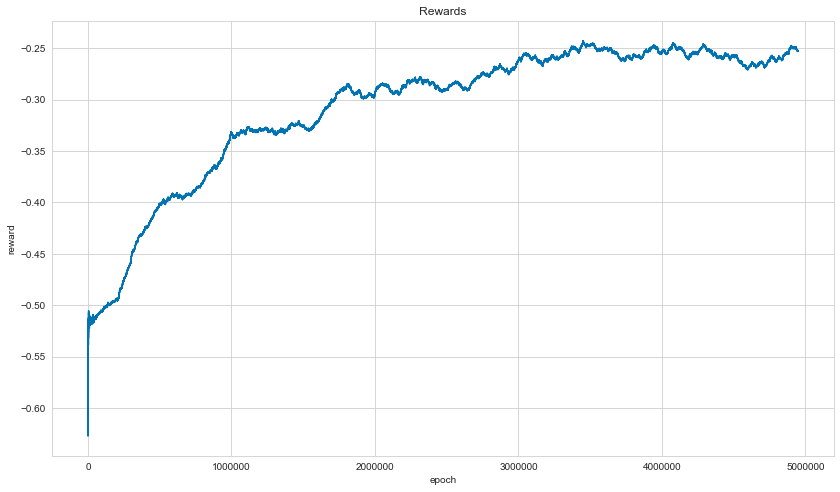

time: 10min 26s


In [100]:
actions_list = [0, 1, 2]
alpha = 1e-4
gamma = 1
n_experiments = 5000000
n_iter_val = 150000
n_iter_mean = 100000

agent = DoubleQLearningAgent(actions_list=actions_list, alpha=alpha, gamma=gamma)
env = DoubleBlackjackEnv()

rewards, mean_rewards = train_agent(
    agent=agent, env=env, n_experiments=n_experiments, 
    verbose=True, n_iter_val=n_iter_val, n_iter_mean=n_iter_mean,
)
env.close()

Да, без e-greedy стало заметно лучше, но на том же уровне, что и раньше.

In [102]:
rewards[-10:]

[-1.0, -1.0, 0.0, 2.0, -1.0, 0.0, -2.0, -1.0, 1.0, -2.0]

time: 37.9 ms


Удвоение ставки работает

In [103]:
dbj_double_q_agent = agent

time: 31.5 ms


In [104]:
sorted(dbj_double_q_agent.Q_1.items())

[((4, 1, False), [0.5102606970394513, 0.458045700435334, 0.5105492613707105]),
 ((4, 2, False), [0.7946256357845184, 0.9284913258476223, 0.5856763495359614]),
 ((4, 3, False), [0.6354917724440873, 0.7832942209367763, 0.6518903174228731]),
 ((4, 4, False),
  [0.5601084855600834, 0.5599567073711306, 0.16607545909638888]),
 ((4, 5, False), [0.3827972164122599, 0.8210826588441013, 0.4839189795059427]),
 ((4, 6, False),
  [0.9574860831676832, 0.7798147090247858, 0.13633336616021896]),
 ((4, 7, False),
  [0.3407630863793786, 0.16024401900296664, 0.3405795591817771]),
 ((4, 8, False), [0.9135953817872839, 0.6554987808526582, 0.3605826281212414]),
 ((4, 9, False),
  [0.13551286927004025, 0.7627583827777918, 0.7515996844294457]),
 ((4, 10, False),
  [0.5513966944253538, 0.5360212594604044, 0.3862076273907076]),
 ((5, 1, False),
  [0.7912024312446182, 0.7911509855464182, 0.18487661348503504]),
 ((5, 2, False),
  [0.8115901089948598, 0.35278401615279015, 0.8117044768947302]),
 ((5, 3, False),
  [

time: 79.1 ms


In [105]:
sorted(dbj_double_q_agent.Q_2.items())

[((4, 1, False), [0.8875315904042607, 0.8885019158698154, 0.2953806798953769]),
 ((4, 2, False), [0.4287147139137323, 0.4319209968472891, 0.7088696594615174]),
 ((4, 3, False), [0.8460022653423483, 0.4144248885429786, 0.8456790689634819]),
 ((4, 4, False),
  [0.016891927402309666, 0.30331038664169396, 0.2699790772718269]),
 ((4, 5, False),
  [0.7077287998115624, 0.34349356810924275, 0.7071592261478522]),
 ((4, 6, False), [0.4623817513215701, 0.9256926012057235, 0.4511051965375986]),
 ((4, 7, False),
  [0.013099868031381806, 0.13463026398958958, 0.05490271176565062]),
 ((4, 8, False), [0.1116117760232731, 0.683548775822301, 0.42178164205864266]),
 ((4, 9, False),
  [0.11768535310954242, 0.33873368690386824, 0.7046183399538544]),
 ((4, 10, False),
  [0.5807128754574795, 0.6689147664612571, 0.053449531557170915]),
 ((5, 1, False),
  [0.47410852166386924, 0.6103587656221879, 0.38336169478956095]),
 ((5, 2, False), [0.5653591130642177, 0.5707428923652296, 0.5699646226360903]),
 ((5, 3, Fals

time: 70.3 ms


In [106]:
print(f"MAE of two Q-functions: {dbj_double_q_agent.mae():.4f}")

MAE of two Q-functions: 0.1797
time: 32.3 ms


### EGreedyDoubleQLearningAgent на ночь

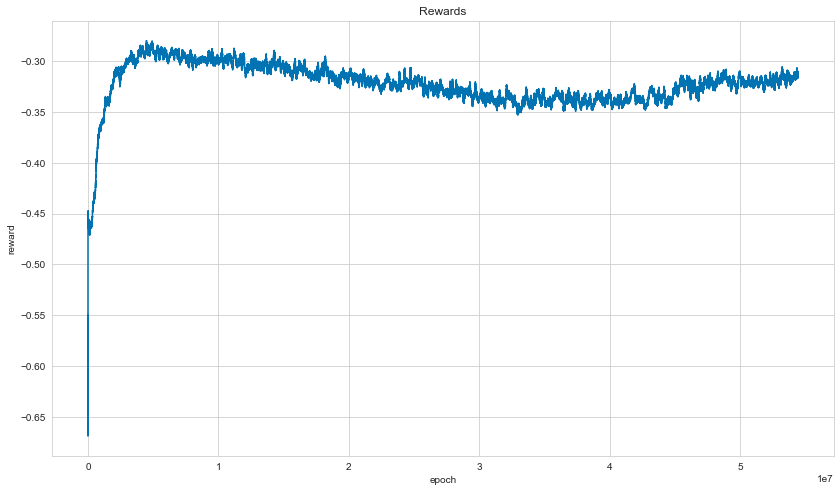

In [ ]:
actions_list = [0, 1, 2]
alpha = 1e-4
gamma = 1
n_experiments = 5000000 * 70
n_iter_val = 150000
n_iter_mean = 100000

agent = EGreedyDoubleQLearningAgent(actions_list=actions_list, alpha=alpha, gamma=gamma)
env = DoubleBlackjackEnv()

rewards, mean_rewards = train_agent(
    agent=agent, env=env, n_experiments=n_experiments, 
    verbose=True, n_iter_val=n_iter_val, n_iter_mean=n_iter_mean,
)
env.close()

Ядро умерло((((

# Часть третья, в главной роли — Дастин Хоффман

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.


Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.

## Задание 6

Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).

In [36]:
import gym
from gym import spaces
from gym.utils import seeding


def cmp(a, b):
    return float(a > b) - float(a < b)

def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class HoffmanDoubleBlackjackEnv(gym.Env):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2),
            spaces.MultiDiscrete([4, 4, 4, 4, 4, 4, 4, 4, 4, 16]),
        ))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        
        # 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
        self.deck = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4)
        
        self.cur_deck = np.array([])
        self.cur_used_cards = np.zeros(10)
        self._invisible_card = None
        
#         # Start the first game
#         self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
            
        
        if action == 1 or action == 2:  # hit: add a card to players hand and return
            self.player.append(self._draw_card())
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
                
        
        if action == 0 or action == 2:  # stick: play out the dealers hand, and score
            done = True
            
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self._draw_card())
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
                
        
        if action == 2:  # double: add a card to players hand and play out the dealers hand, and score x2
            # we take card and play out the dealers hand in prev "if" blocks
            reward *= 2
            
        if done:
            if self._invisible_card is not None:
                self.cur_used_cards[self._invisible_card - 1] += 1
                self._invisible_card = None
        
        return self._get_obs(), reward, done, {}
    
    def _draw_card(self, visible=True):
        if self.cur_deck.shape[0] < 15:
            self.cur_deck = self.np_random.permutation(self.deck)
            self.cur_used_cards = np.zeros(10, dtype=int)
            self._invisible_card = None
            
        card = self.cur_deck[-1]
        self.cur_deck = self.cur_deck[:-1]  # return view without copy
        
        if visible:
            self.cur_used_cards[card - 1] += 1
        else:
            if self._invisible_card is not None:
                raise ValueError(f"invisible_card already exist: {self._invisible_card}; cur_card: {card}")
            self._invisible_card = card
        
        return card
    
    def _draw_hand(self, visible=True):
        return [self._draw_card(), self._draw_card(visible=visible)]

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), tuple(self.cur_used_cards))

    def reset(self):
        self.dealer = self._draw_hand(visible=False)
        self.player = self._draw_hand()
        return self._get_obs()

time: 43.8 ms


In [12]:
import gym
from gym import spaces
from gym.utils import seeding


def cmp(a, b):
    return float(a > b) - float(a < b)

def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class CurrentScoreDoubleBlackjackEnv(gym.Env):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2),
            spaces.Discrete(41),
        ))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        
        # 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
        self.deck = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4)
        
        self.cur_deck = np.array([])
        self.score = 0
        self._invisible_card = None
        
#         # Start the first game
#         self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
            
        
        if action == 1 or action == 2:  # hit: add a card to players hand and return
            self.player.append(self._draw_card())
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
                
        
        if action == 0 or action == 2:  # stick: play out the dealers hand, and score
            done = True
            
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self._draw_card())
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
                
        
        if action == 2:  # double: add a card to players hand and play out the dealers hand, and score x2
            # we take card and play out the dealers hand in prev "if" blocks
            reward *= 2
            
        if done:
            if self._invisible_card is not None:
                self._update_score(card=self._invisible_card)
                self._invisible_card = None
        
        return self._get_obs(), reward, done, {}
    
    def _update_score(self, card):
        if card >= 2 and card <= 6:
            self.score += 1
        elif card == 1 or card == 10:
            self.score -= 1
    
    def _draw_card(self, visible=True):
        if self.cur_deck.shape[0] < 15:
            self.cur_deck = self.np_random.permutation(self.deck)
            self.score = 0
            self._invisible_card = None
            
        card = self.cur_deck[-1]
        self.cur_deck = self.cur_deck[:-1]  # return view without copy
        
        if visible:
            self._update_score(card=card)
        else:
            if self._invisible_card is not None:
                raise ValueError(f"invisible_card already exist: {self._invisible_card}; cur_card: {card}")
            self._invisible_card = card
        
        return card
    
    def _draw_hand(self, visible=True):
        return [self._draw_card(), self._draw_card(visible=visible)]

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), self.score)

    def reset(self):
        self.dealer = self._draw_hand(visible=False)
        self.player = self._draw_hand()
        return self._get_obs()

time: 34.2 ms


## Задание 7

Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

### DoubleQLearning

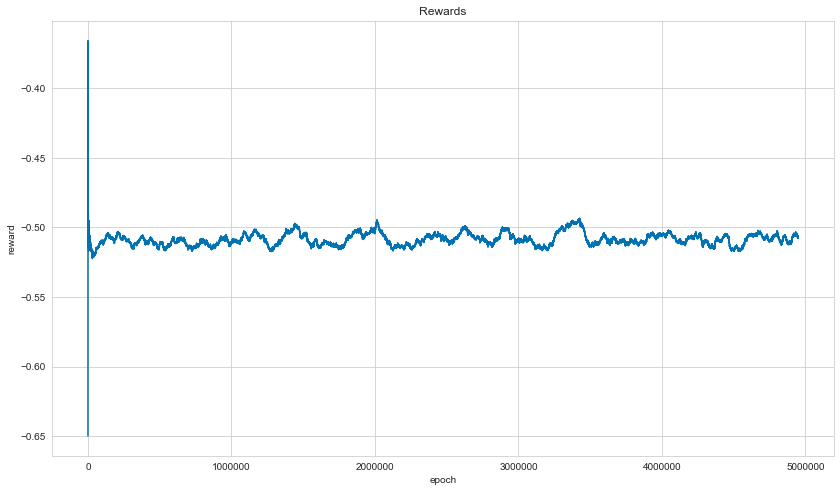

time: 9min 30s


In [41]:
actions_list = [0, 1, 2]
alpha = 1e-4
gamma = 1
n_experiments = 5000000
n_iter_val = 150000
n_iter_mean = 100000

agent = DoubleQLearningAgent(actions_list=actions_list, alpha=alpha, gamma=gamma)
env = HoffmanDoubleBlackjackEnv()

rewards, mean_rewards = train_agent(
    agent=agent, env=env, n_experiments=n_experiments, 
    verbose=True, n_iter_val=n_iter_val, n_iter_mean=n_iter_mean,
)
env.close()

Очень много состояний: ничего не обучается

## Будем действовать методом счетчика

карты от 2 до 6 обозначаются +1, десятки и тузы -1, все остальные 0.

### DoubleQLearning

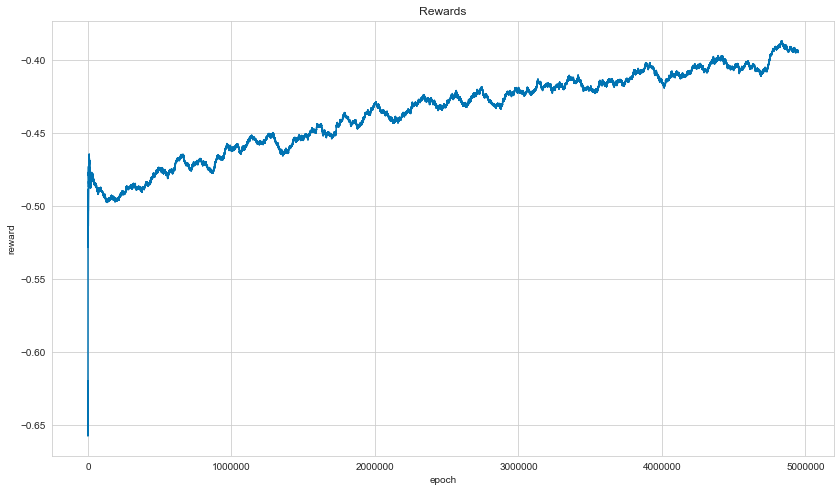

time: 7min 27s


In [48]:
actions_list = [0, 1, 2]
alpha = 1e-4
gamma = 1
n_experiments = 5000000
n_iter_val = 150000
n_iter_mean = 100000

agent = DoubleQLearningAgent(actions_list=actions_list, alpha=alpha, gamma=gamma)
env = CurrentScoreDoubleBlackjackEnv()

rewards, mean_rewards = train_agent(
    agent=agent, env=env, n_experiments=n_experiments, 
    verbose=True, n_iter_val=n_iter_val, n_iter_mean=n_iter_mean,
)
env.close()

In [49]:
score_dbj_double_q_agent = agent

time: 149 ms


In [50]:
sorted(score_dbj_double_q_agent.Q_1.items())

[((4, 1, False, -10),
  [0.8695035488194108, 0.7107618145254166, 0.15991799108329652]),
 ((4, 1, False, -9),
  [0.9879368370077776, 0.05710012243911423, 0.5431733868444921]),
 ((4, 1, False, -8),
  [0.43365949947607507, 0.6270415651117578, 0.9400779031855511]),
 ((4, 1, False, -7),
  [0.23946639784989454, 0.6715580252666322, 0.4470898608472502]),
 ((4, 1, False, -6),
  [0.5906435970723153, 0.5332831775979372, 0.2781797270221068]),
 ((4, 1, False, -5),
  [0.01999009031718474, 0.5177465155111671, 0.11213185581079899]),
 ((4, 1, False, -4),
  [0.13416649514816212, 0.6271211590834852, 0.5446071889529872]),
 ((4, 1, False, -3),
  [0.20804169731444, 0.9974721901172299, 0.7707054952038302]),
 ((4, 1, False, -2),
  [0.6458572625672087, 0.14766979714153125, 0.07862044888737763]),
 ((4, 1, False, -1),
  [0.37045463677413515, 0.5235233751236547, 0.04882386169817709]),
 ((4, 1, False, 0),
  [0.8223223578715155, 0.47541160291622686, 0.6263040385412556]),
 ((4, 1, False, 1),
  [0.6505067869148875, 0

time: 466 ms


In [51]:
sorted(score_dbj_double_q_agent.Q_2.items())

[((4, 1, False, -9),
  [0.3680204131391604, 0.9461060414706075, 0.5496201761043831]),
 ((4, 1, False, -8),
  [0.46821520952978357, 0.09508214599528053, 0.5182871945833938]),
 ((4, 1, False, -7),
  [0.09033314443064289, 0.667702469256868, 0.7243097578198088]),
 ((4, 1, False, -6),
  [0.5893958535580189, 0.2730588717315925, 0.028504550871754852]),
 ((4, 1, False, -5),
  [0.6432635904282221, 0.3354479465671681, 0.4662093211961934]),
 ((4, 1, False, -4),
  [0.8177714132931928, 0.6316010905147361, 0.010768285259073584]),
 ((4, 1, False, -3),
  [0.5301386308337865, 0.5623280517105242, 0.5749381438408435]),
 ((4, 1, False, -2),
  [0.10981296195598089, 0.7722403726932522, 0.6829526589940237]),
 ((4, 1, False, -1),
  [0.43660433776296026, 0.6237992286393534, 0.6834140531983558]),
 ((4, 1, False, 0),
  [0.7937875790639803, 0.7871574471016369, 0.7644599845665058]),
 ((4, 1, False, 1),
  [0.38011276471663935, 0.27911041599547065, 0.9341668338308203]),
 ((4, 1, False, 2),
  [0.6021301319006633, 0.0

time: 332 ms


In [52]:
print(f"MAE of two Q-functions: {score_dbj_double_q_agent.mae():.4f}")

MAE of two Q-functions: 0.2481
time: 145 ms


### DoubleQLearning

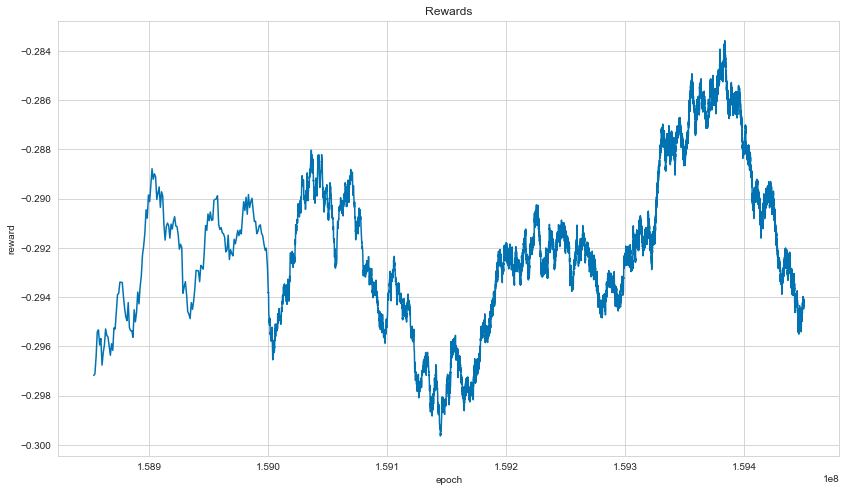

KeyboardInterrupt: 

time: 3h 28min 29s


In [21]:
actions_list = [0, 1, 2]
alpha = 1e-4
gamma = 1
n_experiments = 5000000 * 40
n_iter_val = 150000
n_iter_mean = 100000

agent = DoubleQLearningAgent(actions_list=actions_list, alpha=alpha, gamma=gamma)
env = CurrentScoreDoubleBlackjackEnv()

rewards, mean_rewards = train_agent(
    agent=agent, env=env, n_experiments=n_experiments, 
    verbose=True, n_iter_val=n_iter_val, n_iter_mean=n_iter_mean,
)
env.close()

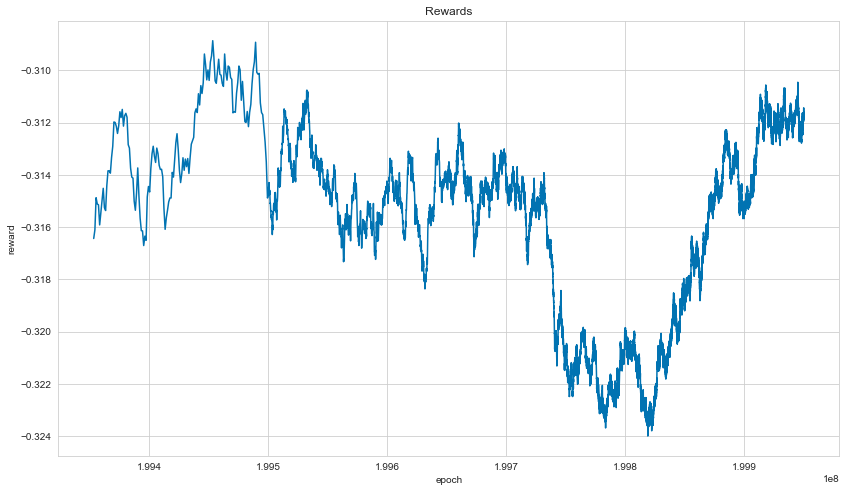

ValueError: too many values to unpack (expected 2)

time: 4h 26min 51s


In [22]:
actions_list = [0, 1, 2]
alpha = 1e-5
gamma = 1
n_experiments = 5000000 * 40
n_iter_val = 150000
n_iter_mean = 100000

# agent = DoubleQLearningAgent(actions_list=actions_list, alpha=alpha, gamma=gamma)
env = CurrentScoreDoubleBlackjackEnv()

rewards, mean_rewards = train_agent(
    agent=agent, env=env, n_experiments=n_experiments, 
    verbose=True, n_iter_val=n_iter_val, n_iter_mean=n_iter_mean,
)
env.close()

# Видимо я что-то делаю не так, раз не получается пробить reward, получаемый на простых правилах(

Судя по сообщениям в чате + рекомендациям с занятия: 
 - валидировать надо по-другому: раз во много итераций остановить обновление весов и просто сыграть 150к игр для получения устойчивой оценки reward)
 - изменение гаммы тоже влияет в лучшую сторону (не очевидно почему gamma < 1 может быть лучше, елси нам не важно за два или три действия мы выйграем?)
 - для хорошей модели надо хотя бы 30 минут
 - добавить natural

natural для базовых правил

In [31]:
n_experiments = 200000
rewards = []
env = gym.make('Blackjack-v0', natural=True)

for _ in tqdm(range(n_experiments)):
    state = env.reset()
    while True:
        action = simple_policy(state)
        state, reward, done, info = env.step(action)
        if done:
            rewards.append(reward)
            break

env.close()
print(f"Expected reward for simple policy: {np.mean(rewards)}")

Expected reward for simple policy: -0.1810475
time: 15.6 s


Доработаю процесс валидации

In [23]:
def play_game(env, agent, with_update: bool = False):
    state = env.reset()
        
    while True:
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        if with_update:
            agent.update(state, action, reward, next_state)

        if done:
            break
    
    return reward

time: 212 ms


In [26]:
def train_agent_correct_val(
    agent, 
    env, 
    n_experiments: int = 10000000, 
    verbose: bool = False, 
    n_iter_val: int = 150000,
    val_freq: int = 500000,
) -> typing.Tuple[typing.List[float], typing.List[float]]:
    
    epochs = []
    mean_rewards = []
    
    for i in tqdm(range(n_experiments)):
        play_game(env=env, agent=agent, with_update=True)
        
        if (i + 1) % val_freq == 0:
            mean_reward = np.mean([
                play_game(env=env, agent=agent, with_update=False)
                for j in tqdm(range(n_iter_val))
            ])
            mean_rewards.append(mean_reward)
            epochs.append(i)
            
            if verbose:
                clear_output()

                fig = plot_rewards(epochs, mean_rewards)
                plt.show()

    return epochs, mean_rewards

time: 27.6 ms


In [25]:
def plot_rewards(epochs: typing.List[int], rewards: typing.List[float]):
    figure = plt.figure(figsize=(14, 8))
    ax = figure.add_subplot(1, 1, 1)
    
    ax.plot(epochs, rewards)
    ax.set_title("Rewards")
    ax.set_xlabel("epoch")
    ax.set_ylabel("reward")

    return figure

time: 32.2 ms


### DoubleQLearning

In [35]:
params2e_r_pair = {}

time: 27.6 ms


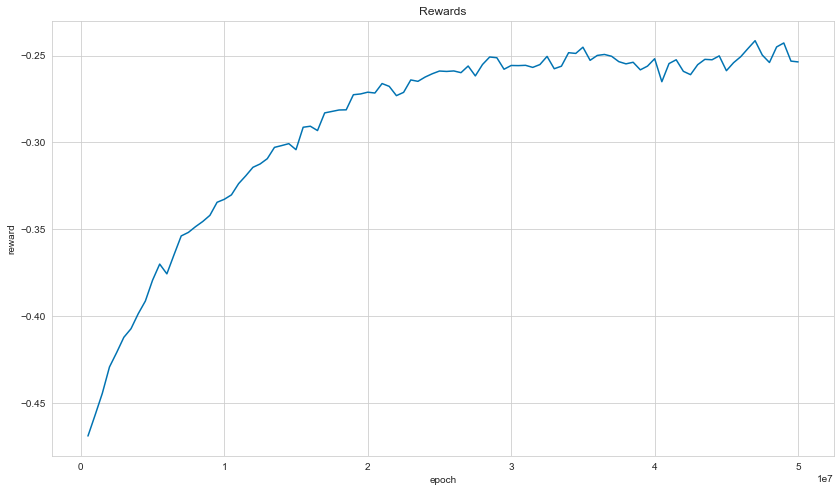

time: 1h 34min 36s


In [37]:
actions_list = [0, 1, 2]
alpha = 1e-4
gamma = 1
n_experiments = 50000000
n_iter_val = 300000
val_freq = 500000

agent = DoubleQLearningAgent(actions_list=actions_list, alpha=alpha, gamma=gamma)
env = CurrentScoreDoubleBlackjackEnv(natural=True)

epochs, mean_rewards = train_agent_correct_val(
    agent=agent, env=env, n_experiments=n_experiments,
    verbose=True, n_iter_val=n_iter_val, val_freq=val_freq,
)
env.close()
params2e_r_pair[f"alpha={alpha}, gamma={gamma}"] = (epochs, mean_rewards)

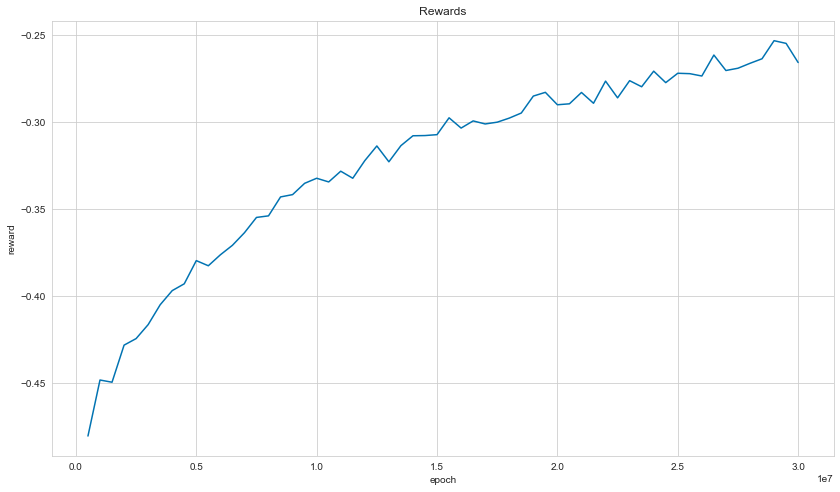

time: 51min 21s


In [33]:
actions_list = [0, 1, 2]
alpha = 1e-4
gamma = 0.99
n_experiments = 30000000
n_iter_val = 300000
val_freq = 500000

agent = DoubleQLearningAgent(actions_list=actions_list, alpha=alpha, gamma=gamma)
env = CurrentScoreDoubleBlackjackEnv(natural=True)

epochs, mean_rewards = train_agent_correct_val(
    agent=agent, env=env, n_experiments=n_experiments,
    verbose=True, n_iter_val=n_iter_val, val_freq=val_freq,
)
env.close()
params2e_r_pair[f"alpha={alpha}, gamma={gamma}"] = (epochs, mean_rewards)

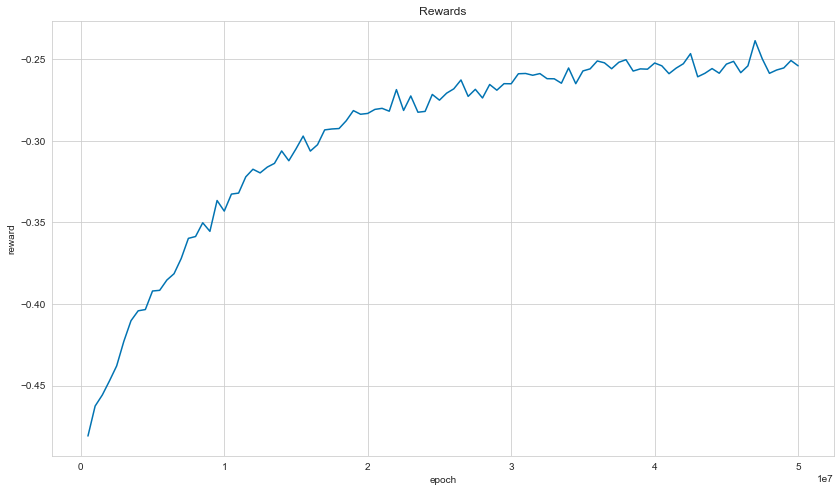

time: 1h 28min 26s


In [38]:
actions_list = [0, 1, 2]
alpha = 1e-4
gamma = 0.95
n_experiments = 50000000
n_iter_val = 300000
val_freq = 500000

agent = DoubleQLearningAgent(actions_list=actions_list, alpha=alpha, gamma=gamma)
env = CurrentScoreDoubleBlackjackEnv(natural=True)

epochs, mean_rewards = train_agent_correct_val(
    agent=agent, env=env, n_experiments=n_experiments,
    verbose=True, n_iter_val=n_iter_val, val_freq=val_freq,
)
env.close()
params2e_r_pair[f"alpha={alpha}, gamma={gamma}, env=score"] = (epochs, mean_rewards)

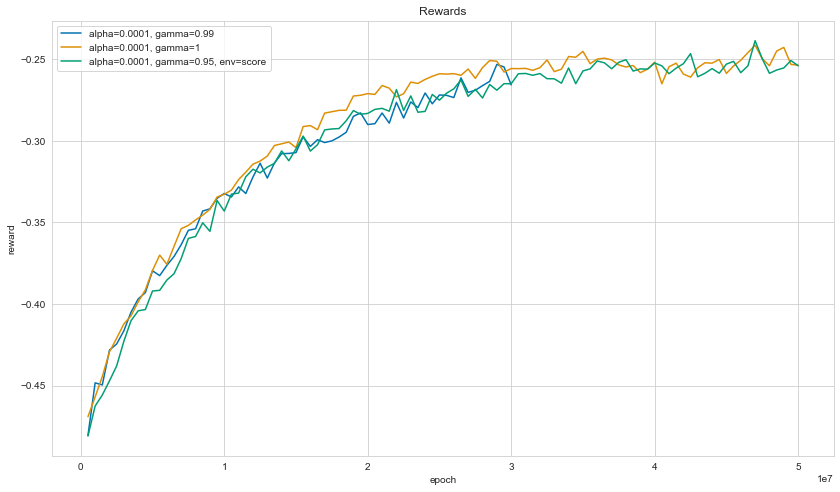

time: 455 ms


In [41]:
figure = plt.figure(figsize=(14, 8))
ax = figure.add_subplot(1, 1, 1)

for label, (epochs, mean_rewards) in params2e_r_pair.items():
    ax.plot(epochs, mean_rewards, label=label)
    
ax.set_title("Rewards")
ax.set_xlabel("epoch")
ax.set_ylabel("reward")
ax.legend()

plt.show()

Разницы нет

## Для изначальной среды

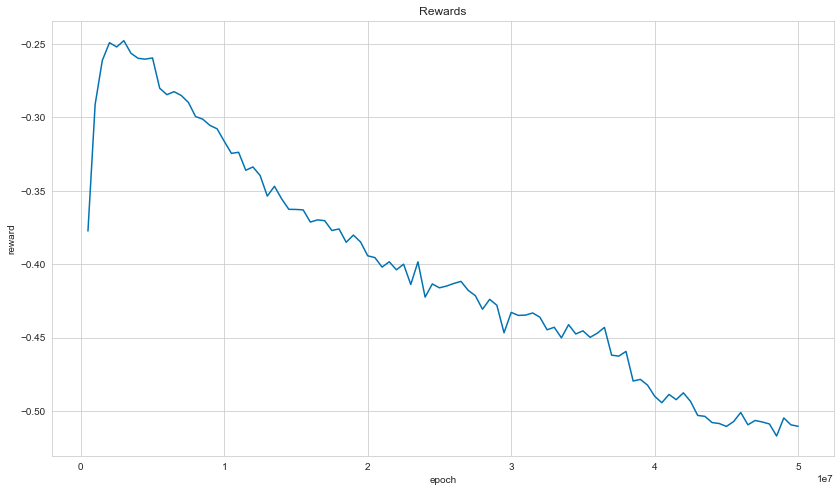

time: 2h 24min 3s


In [42]:
actions_list = [0, 1]
alpha = 1e-4
gamma = 1
n_experiments = 50000000
n_iter_val = 300000
val_freq = 500000

agent = DoubleQLearningAgent(actions_list=actions_list, alpha=alpha, gamma=gamma)
env = gym.make('Blackjack-v0', natural=True)

epochs, mean_rewards = train_agent_correct_val(
    agent=agent, env=env, n_experiments=n_experiments,
    verbose=True, n_iter_val=n_iter_val, val_freq=val_freq,
)
env.close()
params2e_r_pair[f"alpha={alpha}, gamma={gamma}, env=raw"] = (epochs, mean_rewards)

## С удвоением

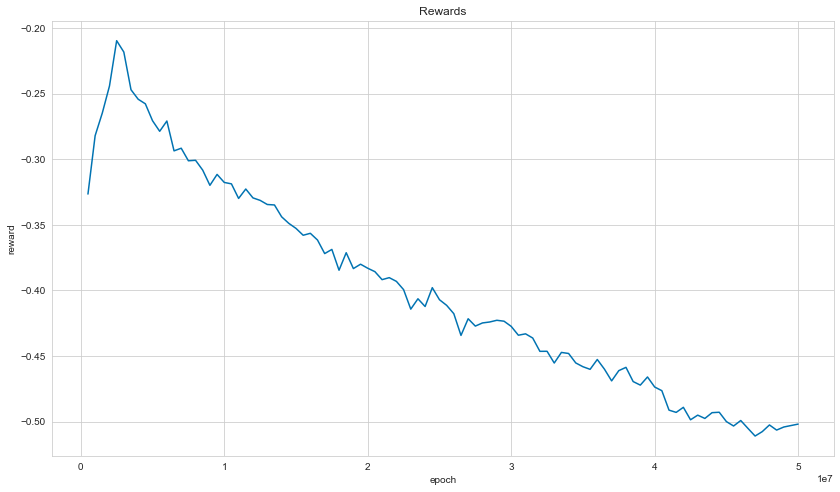

time: 2h 20min 47s


In [45]:
actions_list = [0, 1]
alpha = 1e-4
gamma = 1
n_experiments = 50000000
n_iter_val = 300000
val_freq = 500000

agent = DoubleQLearningAgent(actions_list=actions_list, alpha=alpha, gamma=gamma)
env = DoubleBlackjackEnv(natural=True)

epochs, mean_rewards = train_agent_correct_val(
    agent=agent, env=env, n_experiments=n_experiments,
    verbose=True, n_iter_val=n_iter_val, val_freq=val_freq,
)
env.close()
params2e_r_pair[f"alpha={alpha}, gamma={gamma}, env=double"] = (epochs, mean_rewards)

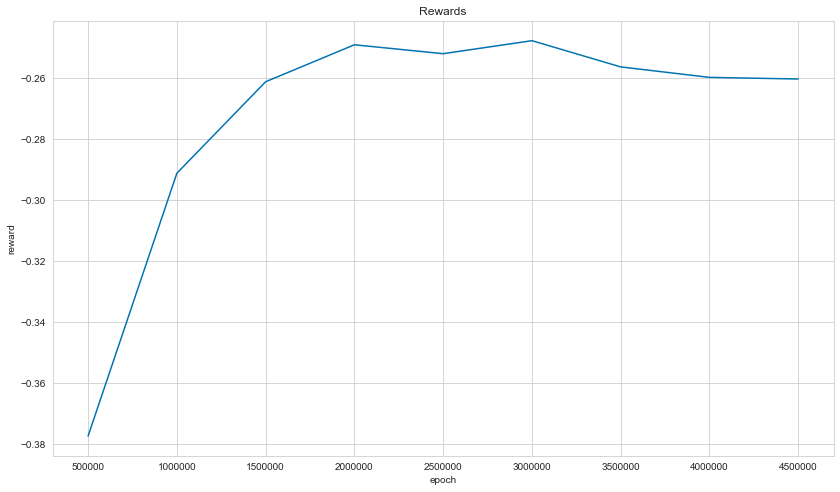

In [ ]:
actions_list = [0, 1]
alpha = 1e-4
gamma = 1
n_experiments = 50000000
n_iter_val = 300000
val_freq = 500000

agent = QLearningAgent(actions_list=actions_list, alpha=alpha, gamma=gamma)
env = gym.make('Blackjack-v0', natural=True)

epochs, mean_rewards = train_agent_correct_val(
    agent=agent, env=env, n_experiments=n_experiments,
    verbose=True, n_iter_val=n_iter_val, val_freq=val_freq,
)
env.close()
params2e_r_pair[f"alpha={alpha}, gamma={gamma}, env=raw, q"] = (epochs, mean_rewards)

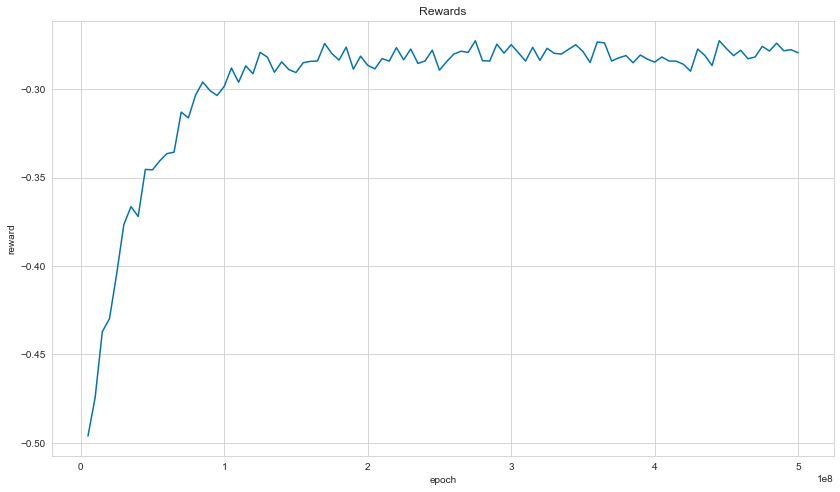

time: 9h 41min 48s


In [47]:
actions_list = [0, 1, 2]
alpha = 1e-5
gamma = 1
n_experiments = 500000000
n_iter_val = 300000
val_freq = 5000000

agent = QLearningAgent(actions_list=actions_list, alpha=alpha, gamma=gamma)
env = CurrentScoreDoubleBlackjackEnv(natural=True)

epochs, mean_rewards = train_agent_correct_val(
    agent=agent, env=env, n_experiments=n_experiments,
    verbose=True, n_iter_val=n_iter_val, val_freq=val_freq,
)
env.close()
params2e_r_pair[f"alpha={alpha}, gamma={gamma}, env=score, q"] = (epochs, mean_rewards)

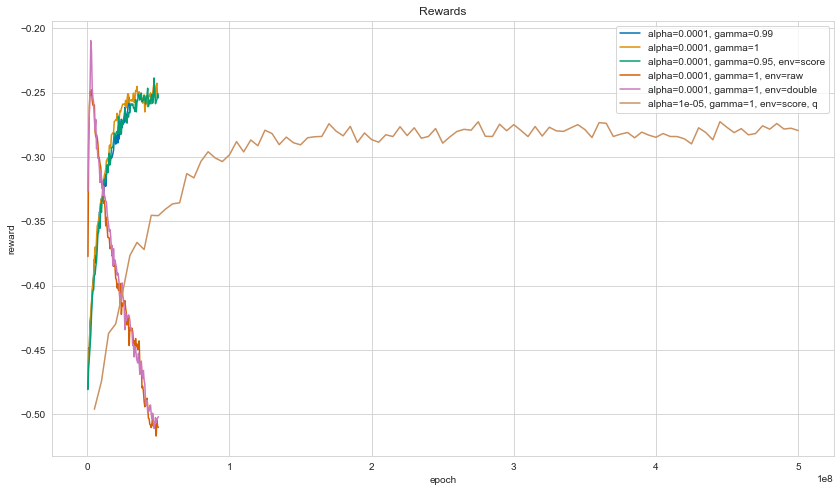

time: 557 ms


In [48]:
figure = plt.figure(figsize=(14, 8))
ax = figure.add_subplot(1, 1, 1)

for label, (epochs, mean_rewards) in params2e_r_pair.items():
    ax.plot(epochs, mean_rewards, label=label)
    
ax.set_title("Rewards")
ax.set_xlabel("epoch")
ax.set_ylabel("reward")
ax.legend()

plt.show()

# Вывод

Не знаю, что я делаю не так и почему у других получается обыграть казино, а у меня не выходит даже обыграть базовые правила!

Буду очень признателен, если вы дадите фидбек, что стоило делать по-другому, потому что у меня такая ситуация с любым заданием в ML, где нужно достигнуть какого-либо уровня качества или соревнования с однокурсниками: я почти всегда оказываюсь в хвосте, либо не дотягиваю до лучших бейзлайнов, при этом не сказал бы что трачу мало времени на задание.